In [2]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [3]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [4]:
LANDMARK_INDEXES = [
    76, 306,  # mouth corners
    74, 73, 72, 11, 302, 303, 304, # upper lip
    90, 180, 85, 16, 315, 404, 320, # lower lip
    33, 161, 159, 157, 133, 154, 145, 163,  # left eye
    70, 63, 105, 66, 107,  # left eyebrow
    362, 384, 386, 388, 263, 390, 374, 381,  # right eye
    300, 293, 334, 296, 336,  # right eyebrow
    1, 5, 197, 168  # nose
]

### Wizualizacja wybranych punktów

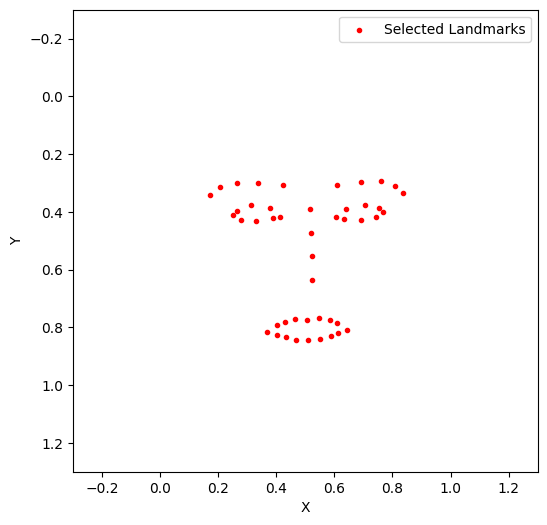

In [5]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

## Zdobycie danych

In [6]:
from utils import load_data, get_selected_landmarks

all_data, all_labels = load_data('ravdess')
all_data = get_selected_landmarks(all_data, LANDMARK_INDEXES)

## Preprocessing danych

In [ ]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2012, 157, 46, 2])
torch.Size([2012, 8])


# MODEL TORCH

### W podejściu wykorzystane zostaną 2 modele - pierwszy z nich będzie siecią konwolucyjną 2d, która będzie miała za zadanie nauczyć się rozpoznawać cechy charakterystyczne dla wybranej klatki (zbioru współrzędnych pkt charakterystycznych). Do klasyfikacji szeregu czasowego zostanie wykorzystana sekwencyjna sieć neuronowa LSTM.

## Zbudowanie modelu ekstrakcji cech

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()

        self.model_type = 'torch_lstm'
        self.name = 'emotion_classifier_selected_landmarks'

        
        # Spatial feature extraction using Conv1D
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layers for temporal feature extraction
        self.lstm1 = nn.LSTM(input_size=736, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)  # 8 emotion classes

    def forward(self, x):
        # x shape: (batch_size, frames, landmarks, coordinates)
        batch_size, frames, landmarks, coordinates = x.shape
        
        # Reshape for Conv1D: (batch_size * frames, landmarks, coordinates)
        x = x.view(-1, landmarks, coordinates).permute(0, 2, 1)
        
        # Spatial feature extraction
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # (batch_size, frames, features)
        
        # Temporal feature extraction
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        
        # Classification
        x = self.fc(x[:, -1, :])  # Take the last timestep's output
        return x

In [11]:
from torch.optim import Adam

model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Trening modelu

In [12]:
from utils.model_functions import train_torch_model

train_torch_model(model, criterion, optimizer, X_train, y_train, X_val, y_val)

Epoch 1/300, Train Loss: 130.5761, Train Acc: 0.1322, Val Loss: 28.9041, Val Acc: 0.1276
Epoch 2/300, Train Loss: 130.0588, Train Acc: 0.1387, Val Loss: 28.8700, Val Acc: 0.1276
Epoch 3/300, Train Loss: 130.0771, Train Acc: 0.1387, Val Loss: 28.8602, Val Acc: 0.1276
Epoch 4/300, Train Loss: 130.0288, Train Acc: 0.1352, Val Loss: 28.8615, Val Acc: 0.1369
Epoch 5/300, Train Loss: 130.0386, Train Acc: 0.1287, Val Loss: 28.8591, Val Acc: 0.1323
Epoch 6/300, Train Loss: 130.0078, Train Acc: 0.1223, Val Loss: 28.8593, Val Acc: 0.1369
Epoch 7/300, Train Loss: 130.0205, Train Acc: 0.1188, Val Loss: 28.8603, Val Acc: 0.1276
Epoch 8/300, Train Loss: 130.0189, Train Acc: 0.1342, Val Loss: 28.8630, Val Acc: 0.1369
Epoch 9/300, Train Loss: 129.9844, Train Acc: 0.1307, Val Loss: 28.8562, Val Acc: 0.1276
Epoch 10/300, Train Loss: 130.0325, Train Acc: 0.1287, Val Loss: 28.8575, Val Acc: 0.1276
Epoch 11/300, Train Loss: 130.0348, Train Acc: 0.1352, Val Loss: 28.8552, Val Acc: 0.1346


KeyboardInterrupt: 

## Ewaluacja modelu

In [ ]:
from utils.model_functions import eval_torch_model

eval_torch_model(model, criterion, X_test, y_test)

Test Loss: 0.0418, Test Accuracy: 0.5278
